# LOAN DEFAULT NOTEBOOK

## LOADING THE NECESSARY LIBRARIES

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
#Import some libraries
import pandas as pd

pd.options.display.max_rows = 2200
pd.options.display.max_columns = 2200

import numpy as np
import gc
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier as catt
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import precision_score
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
GPU_ENABLED = True

In [ ]:
gc.collect()

50

In [ ]:
#Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/LOan_default"

Mounted at /content/gdrive


In [ ]:
# path = "./"

## LOAD THE DATASETS VIEW AND CLEAN THEM


In [ ]:
#import data
trainperf = pd.read_csv(path+'/trainperf.csv')
trainprev = pd.read_csv(path+'/trainprevloans.csv')
traindemo = pd.read_csv(path+'/traindemographics.csv')
testperf=  pd.read_csv(path+'/testperf.csv')
testprev=  pd.read_csv(path+'/testprevloans.csv')
testdemo=  pd.read_csv(path+'/testdemographics.csv')
submission = pd.read_csv(path+'/SampleSubmission.csv')

In [ ]:
trainperf.head(2)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good


In [ ]:
trainprev.head(2)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000


In [ ]:
traindemo.head(2)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN


In [ ]:
trainprev.shape,trainperf.shape,traindemo.shape

((18183, 12), (4368, 10), (4346, 9))

In [ ]:
testperf.shape,testprev.shape,traindemo.shape

((1450, 9), (5907, 12), (4346, 9))

In [ ]:
duplicate = trainperf[trainperf['customerid'].duplicated()]
duplicate

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag


In [ ]:
duplicate = testperf[testperf['customerid'].duplicated()]
duplicate

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby


In [ ]:
# duplicate = trainprev[trainprev['customerid'].duplicated()]
# duplicate

In [ ]:
duplicate = traindemo[traindemo['customerid'].duplicated()]
duplicate.shape

(12, 9)

In [ ]:
duplicate = testdemo[testdemo['customerid'].duplicated()]
duplicate.shape

(3, 9)

In [ ]:
# traindemo = traindemo.drop_duplicates(subset="customerid")
# testdemo = testdemo.drop_duplicates(subset="customerid")

In [ ]:
traindemo.duplicated().sum(),testdemo.duplicated().sum()

(12, 3)

In [ ]:

traindemo.drop(['level_of_education_clients','bank_branch_clients'], 1, inplace = True)
testdemo.drop(['level_of_education_clients','bank_branch_clients'], 1, inplace = True)


In [ ]:
cat_cols = traindemo.select_dtypes('object').columns
for col in traindemo.columns:

  if col in cat_cols:
    traindemo[col] = traindemo[col].astype('category')

In [ ]:
cat_cols = testdemo.select_dtypes('object').columns
for col in testdemo.columns:

  if col in cat_cols:
    testdemo[col] = testdemo[col].astype('category')

In [ ]:
traindemo['employment_status_clients'] = traindemo['employment_status_clients'].cat.add_categories('Unknown')
traindemo['employment_status_clients'].fillna('Unknown', inplace =True) 

In [ ]:
testdemo['employment_status_clients'] = testdemo['employment_status_clients'].cat.add_categories('Unknown')
testdemo['employment_status_clients'].fillna('Unknown', inplace =True) 

In [ ]:
trainprev.shape,trainperf.shape,traindemo.shape

((18183, 12), (4368, 10), (4346, 7))

In [ ]:
trainperf = trainperf.merge(traindemo, how='left', on='customerid')
trainperf.shape

(4376, 16)

In [ ]:
testperf = testperf.merge(testdemo, how='left', on='customerid')
testperf.shape

(1450, 15)

In [ ]:
trainperf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,Permanent
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,Permanent
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,Permanent
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,Permanent
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,Permanent


In [ ]:
trainprev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


## PRELIMINARY FEATURE ENGINEERING

In [ ]:
#Find the difference in the date attributes
trainprev['closed_creation_diff'] = (pd.to_datetime(trainprev["closeddate"]) - pd.to_datetime(trainprev['creationdate'])).dt.days   
trainprev['repaid_due_diff'] = (pd.to_datetime(trainprev["firstrepaiddate"]) - pd.to_datetime(trainprev['firstduedate'])).dt.days   
trainprev['creation_approved_diff'] = (pd.to_datetime(trainprev["creationdate"]) - pd.to_datetime(trainprev['approveddate'])).dt.days

# trainperf['creation_approved_diff'] = (pd.to_datetime(trainperf["creationdate"]) - pd.to_datetime(trainperf['approveddate'])).dt.days
#find the difference in the totaldue and loan amount
trainprev['totaldue_loanamount_diff'] = trainprev["totaldue"] - trainprev['loanamount']

In [ ]:
#Find the ndifference in the date attributes
testprev['closed_creation_diff'] = (pd.to_datetime(testprev["closeddate"]) - pd.to_datetime(testprev['creationdate'])).dt.days   
testprev['repaid_due_diff'] = (pd.to_datetime(testprev["firstrepaiddate"]) - pd.to_datetime(testprev['firstduedate'])).dt.days   
testprev['creation_approved_diff'] = (pd.to_datetime(testprev["creationdate"]) - pd.to_datetime(testprev['approveddate'])).dt.days

# testperf['creation_approved_diff'] = (pd.to_datetime(testperf["creationdate"]) - pd.to_datetime(testperf['approveddate'])).dt.days
#find the difference in the totaldue and loan amount
testprev['totaldue_loanamount_diff'] = testprev["totaldue"] - testprev['loanamount']

In [ ]:
trainperf['birthdate'] =  pd.to_datetime(trainperf['birthdate'])
trainperf['Birthdate_year']=trainperf['birthdate'].dt.year 
trainperf['Birthddate_day']=trainperf['birthdate'].dt.day  
trainperf['Birthdate_month']=trainperf['birthdate'].dt.month
trainperf['age'] = trainperf['Birthdate_month'] + trainperf['Birthddate_day'] + trainperf['Birthdate_year']

trainperf["good_bad_flag"] = le.fit_transform(trainperf["good_bad_flag"])

In [ ]:
testperf['birthdate'] =  pd.to_datetime(testperf['birthdate'])
testperf['Birthdate_year']=testperf['birthdate'].dt.year 
testperf['Birthddate_day']=testperf['birthdate'].dt.day  
testperf['Birthdate_month']=testperf['birthdate'].dt.month
testperf['age'] = testperf['Birthdate_month'] + testperf['Birthddate_day'] + testperf['Birthdate_year']

In [ ]:
trainprevgroups = trainprev.groupby('customerid').agg(
             loannumber_count = ('loannumber','count'),
             loannumber_sum = ('loannumber','sum'),


             closed_creation_diff_sum = ("closed_creation_diff", "sum"),

             repaid_due_diff_sum = ("repaid_due_diff", "sum"),


             creation_approved_diff_sum = ("creation_approved_diff", "sum"),


             loanamount_sum = ("loanamount", "sum"),

             totaldue_sum = ("totaldue", "sum"),

    
             termdays_sum = ("termdays", "sum"),

    
             totaldue_loanamount_diff_sum = ("totaldue_loanamount_diff", "sum"),).reset_index()

In [ ]:
trainprevgroups.head()

,customerid,loannumber_count,loannumber_sum,closed_creation_diff_sum,repaid_due_diff_sum,creation_approved_diff_sum,loanamount_sum,totaldue_sum,termdays_sum,totaldue_loanamount_diff_sum
0,8a1088a0484472eb01484669e3ce4e0b,1,1,22,6,-1,10000.0,11500.0,15,1500.0
1,8a1a1e7e4f707f8b014f797718316cad,4,10,125,-1,-4,70000.0,89500.0,150,19500.0
2,8a1a32fc49b632520149c3b8fdf85139,7,28,129,-3,-7,90000.0,106500.0,135,16500.0
3,8a1eb5ba49a682300149c3c068b806c7,8,36,228,-25,-8,130000.0,162400.0,270,32400.0
4,8a1edbf14734127f0147356fdb1b1eb2,2,3,36,-8,-2,20000.0,24500.0,45,4500.0


In [ ]:
testprevgroups = testprev.groupby('customerid').agg(
             loannumber_count = ('loannumber','count'),
             loannumber_sum = ('loannumber','sum'),


             closed_creation_diff_sum = ("closed_creation_diff", "sum"),

             repaid_due_diff_sum = ("repaid_due_diff", "sum"),


             creation_approved_diff_sum = ("creation_approved_diff", "sum"),


             loanamount_sum = ("loanamount", "sum"),

             totaldue_sum = ("totaldue", "sum"),

    
             termdays_sum = ("termdays", "sum"),

    
             totaldue_loanamount_diff_sum = ("totaldue_loanamount_diff", "sum"),).reset_index()

In [ ]:
train = trainperf.merge(trainprevgroups, how='left', on='customerid')
train.shape

(4376, 29)

In [ ]:
test = testperf.merge(testprevgroups, how='left', on='customerid')
test.shape

(1450, 28)

In [ ]:
#view the data types in the data data
train.head(2)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,Birthdate_year,Birthddate_day,Birthdate_month,age,loannumber_count,loannumber_sum,closed_creation_diff_sum,repaid_due_diff_sum,creation_approved_diff_sum,loanamount_sum,totaldue_sum,termdays_sum,totaldue_loanamount_diff_sum
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,1,1972-01-15,Other,3.432010,6.433055,Diamond Bank,Permanent,1972.0,15.0,1.0,1988.0,11.0,66.0,325.0,-10.0,-11.0,200000.0,242900.0,330.0,42900.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,1,1985-08-23,Savings,3.885298,7.320700,GT Bank,Permanent,1985.0,23.0,8.0,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test.shape,train.shape

((1450, 28), (4376, 29))

## EXPLORATORY DATA ANALYSIS ON THE TARGET

1    3423
0     953
Name: good_bad_flag, dtype: int64


Text(0.5, 0, 'good_bad_flag')

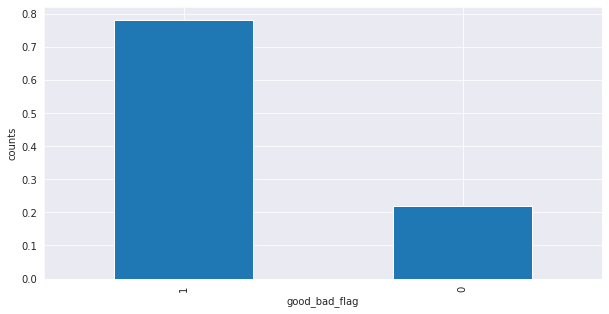

In [ ]:
#Check if the predictor class is balanced 
print(train['good_bad_flag'].value_counts())
plt.figure(figsize=(10,5))
train['good_bad_flag'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('good_bad_flag')

## DATA PREPARATION

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
df = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
#check for missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_data = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_data

,column_name,percent_missing
customerid,customerid,0.000000
systemloanid,systemloanid,0.000000
loannumber,loannumber,0.000000
approveddate,approveddate,0.000000
creationdate,creationdate,0.000000
loanamount,loanamount,0.000000
totaldue,totaldue,0.000000
termdays,termdays,0.000000
referredby,referredby,86.731892
good_bad_flag,good_bad_flag,24.888431


In [ ]:

df.drop(['customerid','systemloanid','creationdate','approveddate','referredby','birthdate','Birthdate_year','Birthdate_month','Birthddate_day','approveddate','creationdate'], 1, inplace = True)


DATA MANIPULATION

In [ ]:
df.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag',
       'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients', 'age',
       'loannumber_count', 'loannumber_sum', 'closed_creation_diff_sum',
       'repaid_due_diff_sum', 'creation_approved_diff_sum', 'loanamount_sum',
       'totaldue_sum', 'termdays_sum', 'totaldue_loanamount_diff_sum'],
      dtype='object')

In [ ]:
df.head()

,loannumber,loanamount,totaldue,termdays,good_bad_flag,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,loannumber_count,loannumber_sum,closed_creation_diff_sum,repaid_due_diff_sum,creation_approved_diff_sum,loanamount_sum,totaldue_sum,termdays_sum,totaldue_loanamount_diff_sum
0,12,30000.0,34500.0,30,1.0,Other,3.432010,6.433055,Diamond Bank,Permanent,1988.0,11.0,66.0,325.0,-10.0,-11.0,200000.0,242900.0,330.0,42900.0
1,2,15000.0,17250.0,30,1.0,Savings,3.885298,7.320700,GT Bank,Permanent,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,20000.0,22250.0,15,1.0,Other,11.139350,10.292041,EcoBank,Permanent,2011.0,6.0,21.0,109.0,5.0,-6.0,60000.0,70500.0,105.0,10500.0
3,3,10000.0,11500.0,15,1.0,Savings,3.985770,7.491708,First Bank,Permanent,1997.0,2.0,3.0,63.0,15.0,-2.0,20000.0,24500.0,45.0,4500.0
4,9,40000.0,44000.0,30,1.0,Other,7.457913,9.076574,GT Bank,Permanent,2002.0,8.0,36.0,216.0,-25.0,-8.0,150000.0,188400.0,300.0,38400.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   loannumber                    5826 non-null   int64   
 1   loanamount                    5826 non-null   float64 
 2   totaldue                      5826 non-null   float64 
 3   termdays                      5826 non-null   int64   
 4   good_bad_flag                 4376 non-null   float64 
 5   bank_account_type             3662 non-null   category
 6   longitude_gps                 3662 non-null   float64 
 7   latitude_gps                  3662 non-null   float64 
 8   bank_name_clients             3662 non-null   category
 9   employment_status_clients     3662 non-null   category
 10  age                           3662 non-null   float64 
 11  loannumber_count              5809 non-null   float64 
 12  loannumber_sum                5809 non-null   fl

In [ ]:
# df = df.dropna( thresh=13)

In [ ]:
num_cols = df.select_dtypes(exclude='object').columns
cat_cols = df.select_dtypes('object').columns


In [ ]:
for col in df.columns:

  if col in cat_cols:
    df[col] = df[col].astype('category')

In [ ]:
cat_cols = ['bank_account_type', 'bank_name_clients',
       'employment_status_clients']

In [ ]:
df['bank_account_type'] = df['bank_account_type'].cat.add_categories('missing')
df['bank_account_type'].fillna('missing', inplace =True) 

df['bank_name_clients'] = df['bank_name_clients'].cat.add_categories('missing')
df['bank_name_clients'].fillna('missing', inplace =True) 

df['employment_status_clients'] = df['employment_status_clients'].cat.add_categories('missing')
df['employment_status_clients'].fillna('missing', inplace =True) 


In [ ]:
null_num = ["longitude_gps",
"latitude_gps" ,
"age",
"loannumber_count",
"loannumber_sum",            
"closed_creation_diff_sum",
"repaid_due_diff_sum",   
"creation_approved_diff_sum",
"loanamount_sum",
"totaldue_sum",             
"termdays_sum",               
"totaldue_loanamount_diff_sum",]

In [ ]:
for col in df.columns:
  if col in null_num:
    df[col] = df[col].fillna(-9999)

# Confirm that there aren't any missing values
df[df.columns.difference(['good_bad_flag'])].isna().sum()

age                             0
bank_account_type               0
bank_name_clients               0
closed_creation_diff_sum        0
creation_approved_diff_sum      0
employment_status_clients       0
latitude_gps                    0
loanamount                      0
loanamount_sum                  0
loannumber                      0
loannumber_count                0
loannumber_sum                  0
longitude_gps                   0
repaid_due_diff_sum             0
termdays                        0
termdays_sum                    0
totaldue                        0
totaldue_loanamount_diff_sum    0
totaldue_sum                    0
dtype: int64

In [ ]:
data = df.copy()

In [ ]:
data[cat_cols].apply(lambda x: len(x.unique()))

bank_account_type             4
bank_name_clients            19
employment_status_clients     8
dtype: int64

LABEL ENCODING

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_columns = data.select_dtypes("category").columns

data[le_columns] = df[le_columns].apply(le.fit_transform)

data.head()


,loannumber,loanamount,totaldue,termdays,good_bad_flag,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,loannumber_count,loannumber_sum,closed_creation_diff_sum,repaid_due_diff_sum,creation_approved_diff_sum,loanamount_sum,totaldue_sum,termdays_sum,totaldue_loanamount_diff_sum
0,12,30000.0,34500.0,30,1.0,1,3.432010,6.433055,1,1,1988.0,11.0,66.0,325.0,-10.0,-11.0,200000.0,242900.0,330.0,42900.0
1,2,15000.0,17250.0,30,1.0,2,3.885298,7.320700,6,1,2016.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,7,20000.0,22250.0,15,1.0,1,11.139350,10.292041,2,1,2011.0,6.0,21.0,109.0,5.0,-6.0,60000.0,70500.0,105.0,10500.0
3,3,10000.0,11500.0,15,1.0,2,3.985770,7.491708,5,1,1997.0,2.0,3.0,63.0,15.0,-2.0,20000.0,24500.0,45.0,4500.0
4,9,40000.0,44000.0,30,1.0,1,7.457913,9.076574,6,1,2002.0,8.0,36.0,216.0,-25.0,-8.0,150000.0,188400.0,300.0,38400.0


## FREQUENCY ENCODING

In [ ]:
cat = ['loannumber',
 'loanamount',
 'totaldue',
 'termdays',
 'bank_account_type',
 'bank_name_clients',
 'employment_status_clients',
 'age',]

In [ ]:
for i in cat:
    data[i+'_freq'] = data[i].map(data[i].value_counts())

## FEATURE SELECTION

In [ ]:
# Separate train and test data from the combined dataframe
train_df = data[:ntrain]
test_df = data[ntrain:]


target = train_df['good_bad_flag'].copy()




# Check the shapes of the split dataset
train_df.shape, test_df.shape

((4376, 28), (1450, 28))

In [ ]:
train_df.head()

,loannumber,loanamount,totaldue,termdays,good_bad_flag,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,loannumber_count,loannumber_sum,closed_creation_diff_sum,repaid_due_diff_sum,creation_approved_diff_sum,loanamount_sum,totaldue_sum,termdays_sum,totaldue_loanamount_diff_sum,loannumber_freq,loanamount_freq,totaldue_freq,termdays_freq,bank_account_type_freq,bank_name_clients_freq,employment_status_clients_freq,age_freq
0,12,30000.0,34500.0,30,1.0,1,3.432010,6.433055,1,1,1988.0,11.0,66.0,325.0,-10.0,-11.0,200000.0,242900.0,330.0,42900.0,150,732,523,4188,723,244,2629,28
1,2,15000.0,17250.0,30,1.0,2,3.885298,7.320700,6,1,2016.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1862,117,20,4188,2887,1347,2629,92
2,7,20000.0,22250.0,15,1.0,1,11.139350,10.292041,2,1,2011.0,6.0,21.0,109.0,5.0,-6.0,60000.0,70500.0,105.0,10500.0,326,1063,158,1231,723,126,2629,127
3,3,10000.0,11500.0,15,1.0,2,3.985770,7.491708,5,1,1997.0,2.0,3.0,63.0,15.0,-2.0,20000.0,24500.0,45.0,4500.0,883,3293,954,1231,2887,487,2629,97
4,9,40000.0,44000.0,30,1.0,1,7.457913,9.076574,6,1,2002.0,8.0,36.0,216.0,-25.0,-8.0,150000.0,188400.0,300.0,38400.0,219,451,288,4188,723,1347,2629,119


In [ ]:
# Select main columns to be used in training
main_cols = data.columns.difference(['good_bad_flag'])
X = train_df[main_cols]
y = train_df.good_bad_flag
# Create the model with several hyperparameters
model = catt(random_state=103, n_estimators=1000)
#
# Split into training and validation set
import random
random.seed(123)
#
train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 47,stratify=y)
# Train using early stopping
model.fit(train_features, train_y, 
          verbose = 200)

Learning rate set to 0.017589
0:	learn: 0.6851742	total: 50.5ms	remaining: 50.5s
200:	learn: 0.4469972	total: 762ms	remaining: 3.03s
400:	learn: 0.4165697	total: 1.48s	remaining: 2.22s
600:	learn: 0.3855084	total: 2.27s	remaining: 1.5s
800:	learn: 0.3574356	total: 2.99s	remaining: 743ms
999:	learn: 0.3318962	total: 3.75s	remaining: 0us


In [ ]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_cat_varimp(model, train_columns, max_vars=100):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_cat_varimp(model, X.columns)

,feature_name,varimp (%)
19,repaid_due_diff_sum,15.386407
18,longitude_gps,8.694234
0,age,8.266196
6,closed_creation_diff_sum,7.867205
10,latitude_gps,7.086675
1,age_freq,6.580384
4,bank_name_clients,4.675916
5,bank_name_clients_freq,4.439666
24,totaldue_freq,4.374205
8,employment_status_clients,2.704272


In [ ]:
#drop irrelevant columns/variables from X features
columns = []
#
X.drop(columns, inplace=True, axis=1)

In [ ]:
#Dropping highly correlated attributes 
corr = X.corr()
# sns.heatmap(corr)
#
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]

In [ ]:
train = train_df[selected_columns]
test = test_df[selected_columns]

train.shape,test.shape

((4376, 16), (1450, 16))

In [ ]:
train.head()

,age,age_freq,bank_account_type,bank_account_type_freq,bank_name_clients,bank_name_clients_freq,closed_creation_diff_sum,employment_status_clients,employment_status_clients_freq,loanamount,loanamount_freq,loanamount_sum,loannumber_freq,termdays,termdays_freq,totaldue_freq
0,1988.0,28,1,723,1,244,325.0,1,2629,30000.0,732,200000.0,150,30,4188,523
1,2016.0,92,2,2887,6,1347,-9999.0,1,2629,15000.0,117,-9999.0,1862,30,4188,20
2,2011.0,127,1,723,2,126,109.0,1,2629,20000.0,1063,60000.0,326,15,1231,158
3,1997.0,97,2,2887,5,487,63.0,1,2629,10000.0,3293,20000.0,883,15,1231,954
4,2002.0,119,1,723,6,1347,216.0,1,2629,40000.0,451,150000.0,219,30,4188,288


## MODELLING 

In [ ]:
from sklearn.model_selection import StratifiedKFold


In [ ]:
fold_pred=[]
oof_pred = []

params = {'depth': 2,
 'iterations': 22118,
 'leaf_estimation_iterations': 13,
 'learning_rate': 0.10623411047043917,
 'min_data_in_leaf': 22,
 'od_wait': 1501,
 'random_strength': 48.168083618044115,
 'reg_lambda': 78.4381515611718}






fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)#15#5#10
i=1

for fold_count, (train_index, test_index) in enumerate(fold.split(train, target)):
    X_train,X_test = train.iloc[train_index],train.iloc[test_index]
    y_train,y_test = target.iloc[train_index],target.iloc[test_index]
  


    model = catt(**params, random_state=42)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100

    preds= model.predict(X_test)
    print("accuracy: ",(accuracy_score(y_test,preds))) 
    oof_pred.append(accuracy_score(y_test,preds))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(p2)
    

print(np.mean(oof_pred))

accuracy:  0.7842465753424658
accuracy:  0.7965714285714286
accuracy:  0.7862857142857143
accuracy:  0.7897142857142857
accuracy:  0.7897142857142857
0.7893064579256359


In [ ]:
def objective(trial):
    fold_pred=[]
    oof_pred = []


  


    param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        # 'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
    }

    # if GPU_ENABLED:

    #   param["task_type"] = "GPU"
    #   param["bootstrap_type"] = "Poisson"




    fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)#15#5#10
    i=1
    for fold_count, (train_index, test_index) in enumerate(fold.split(train, target)):
        X_train,X_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = target.iloc[train_index],target.iloc[test_index]
        m2 = catt(**param, random_state=42)
        # m2 = lgb.LGBMClassifier(**param)

        m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=500, verbose = False,use_best_model=True)#erly100
        preds=m2.predict(X_test)
        oof_pred.append(accuracy_score(y_test,preds))

    

    return np.mean(oof_pred)


## HYPER PARAMETER OPTIMIZATION

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.8 MB/s 
     |████████████████████████████████| 210 kB 52.5 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 146 kB 54.7 MB/s 
     |████████████████████████████████| 113 kB 51.8 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e2a039527ef0b732568f8172cdc338680ccab9bac142665e68908afa50a20504
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-04-17 14:19:18,387] A new study created in memory with name: no-name-bad6e826-a5d5-47c2-9eeb-fffffd789a54
[I 2022-04-17 14:34:00,442] Trial 0 finished with value: 0.7851926940639269 and parameters: {'iterations': 15464, 'od_wait': 1460, 'learning_rate': 0.11155868132137566, 'reg_lambda': 56.90410837387266, 'random_strength': 35.534888129935666, 'depth': 15, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 11}. Best is trial 0 with value: 0.7851926940639269.
[I 2022-04-17 14:34:04,866] Trial 1 finished with value: 0.7838212654924984 and parameters: {'iterations': 19149, 'od_wait': 1145, 'learning_rate': 0.44972151119355613, 'reg_lambda': 75.95400869349469, 'random_strength': 10.624494411808252, 'depth': 1, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 9}. Best is trial 0 with value: 0.7851926940639269.
[I 2022-04-17 14:34:12,932] Trial 2 finished with value: 0.7835932159165035 and parameters: {'iterations': 9540, 'od_wait': 1411, 'learning_rate': 0.6222508299021515,

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7893064579256359
  Params: 
    iterations: 22118
    od_wait: 1501
    learning_rate: 0.10623411047043917
    reg_lambda: 78.4381515611718
    random_strength: 48.168083618044115
    depth: 2
    min_data_in_leaf: 22
    leaf_estimation_iterations: 13


In [ ]:
trial.params   #best params

{'depth': 2,
 'iterations': 22118,
 'leaf_estimation_iterations': 13,
 'learning_rate': 0.10623411047043917,
 'min_data_in_leaf': 22,
 'od_wait': 1501,
 'random_strength': 48.168083618044115,
 'reg_lambda': 78.4381515611718}

## VISUALIZE THE FEATURE IMPORTANCE AFTER MODELLING

Text(0.5, 1.0, 'CatboostClassifier features importance (top 50):')

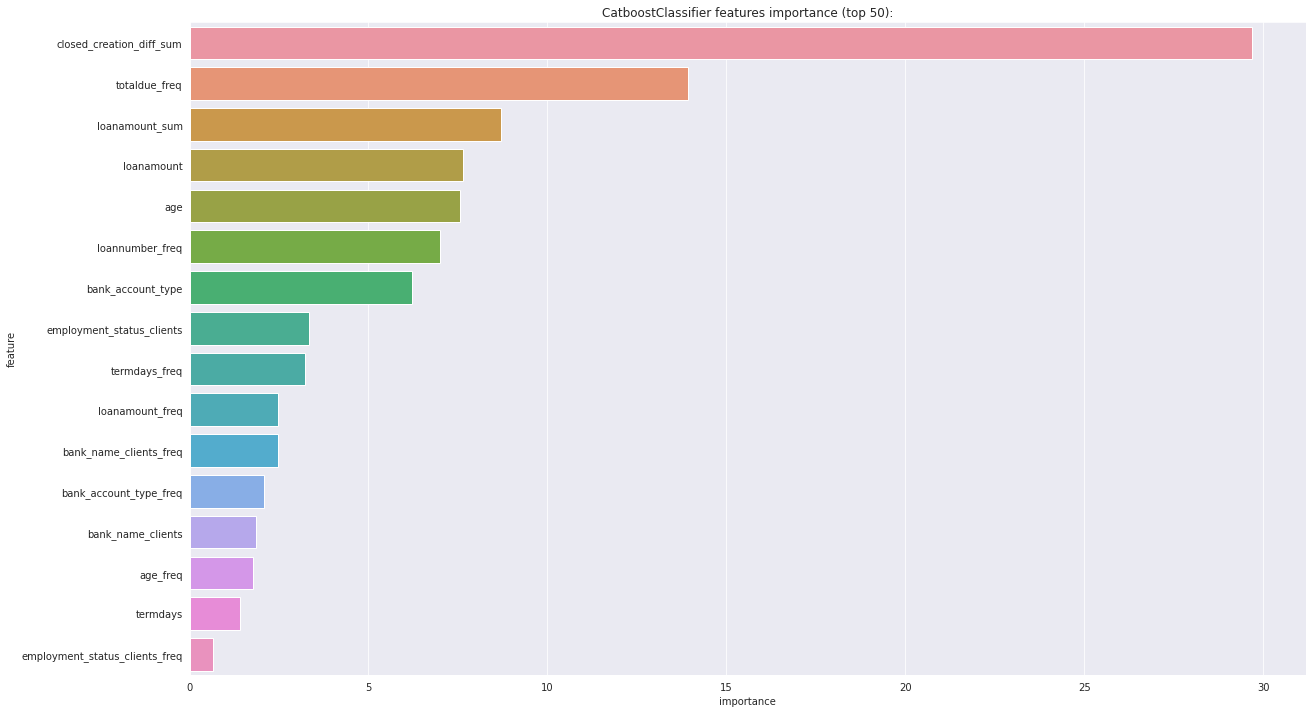

In [ ]:
# # 0.7912081488646163
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sb.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostClassifier features importance (top 50):')

## SUBMISSION

In [ ]:
predict =  np.mean(fold_pred, axis = 0)
predict = np.where( predict > 0.5, 1, 0)
predict

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
submission['Good_Bad_flag'] =  predict

In [ ]:
submission.head(5)

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


In [ ]:
submission.to_csv('cat_Submission_3.csv', index=False)